In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from IPython.display import HTML
from matplotlib import animation
from scipy.stats import multivariate_normal
from typing import Tuple, List
import sys
import os
import open3d as o3d
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
pcd_file_path = "/Users/memento/Downloads/dataset/map.pcd"  # Replace with the actual path to your main .pcd file
frames_folder_path = "/Users/memento/Downloads/dataset/frames"  # Replace with the actual path to your frames folder
# Function to import .pcd file
def import_pcd(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    print(f"Loaded point cloud from: {file_path}")
    print(pcd)
    return pcd

# Function to import frames from a folder
def import_frames(folder_path):
    frame_paths = glob.glob(os.path.join(folder_path, '*.pcd'))
    frames = []
    for frame_path in frame_paths:
        frame = o3d.io.read_point_cloud(frame_path)
        frames.append(frame)
    print(f"Loaded {len(frames)} frames from: {folder_path}")
    return frames

# Load the main point cloud
pcd = import_pcd(pcd_file_path)

# Load the frame point clouds
frames = import_frames(frames_folder_path)


[Open3D WARNING] Read PCD failed: unable to open file: /Users/memento/Downloads/dataset/map.pcd
Loaded point cloud from: /Users/memento/Downloads/dataset/map.pcd
PointCloud with 0 points.
Loaded 0 frames from: /Users/memento/Downloads/dataset/frames


Loaded point cloud from: /Users/memento/Downloads/dataset/map.pcd
PointCloud with 143949 points.
Loaded 1014 frames from: /Users/memento/Downloads/dataset/frames
Number of points in the point cloud: 143949
First few points:
 [[133.89009   -17.641052   -2.401618 ]
 [134.14427   -17.450872   -2.4064834]
 [ 49.811348  -17.239689   -2.4008601]
 [ 50.043064  -17.023172   -2.4048882]
 [ 99.828598  -17.044436   -2.4029672]]


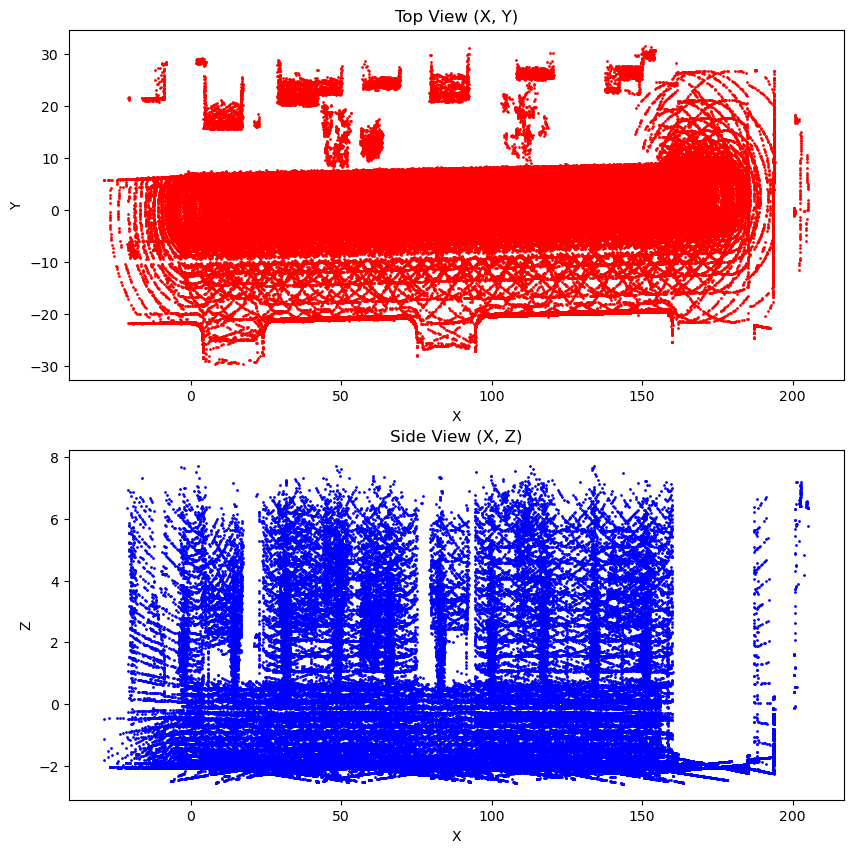

In [45]:
def import_pcd(file_path):
    pcd = o3d.io.read_point_cloud(file_path)
    print(f"Loaded point cloud from: {file_path}")
    print(pcd)
    return pcd

# Function to import frames from a folder
def import_frames(folder_path):
    frame_paths = glob.glob(os.path.join(folder_path, '*.pcd'))
    frames = []
    for frame_path in frame_paths:
        frame = o3d.io.read_point_cloud(frame_path)
        frames.append(frame)
    print(f"Loaded {len(frames)} frames from: {folder_path}")
    return frames

# Load the main point cloud
pcd = import_pcd(pcd_file_path)

# Load the frame point clouds
frames = import_frames(frames_folder_path)

# Function to convert Open3D point cloud to numpy array
def pcd_to_numpy(pcd):
    return np.asarray(pcd.points)

# Function to visualize point cloud using matplotlib
def visualize_point_cloud(pcd_np):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Top view (X, Y)
    axs[0].scatter(pcd_np[:, 0], pcd_np[:, 1], c='r', marker='o', s=1)
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_title('Top View (X, Y)')

    # Side view (X, Z)
    axs[1].scatter(pcd_np[:, 0], pcd_np[:, 2], c='b', marker='o', s=1)
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Z')
    axs[1].set_title('Side View (X, Z)')

    plt.show()

# Convert the loaded point cloud to numpy array
pcd_np = pcd_to_numpy(pcd)

# Debug: Print the number of points and first few points to verify loading
print("Number of points in the point cloud:", len(pcd_np))
print("First few points:\n", pcd_np[:5])

# Visualize the point cloud using matplotlib
visualize_point_cloud(pcd_np)


In [46]:
class Pose:
    """
    Pose class
    """
    def __init__(self, x: float, y: float, z: float, roll: float, pitch: float, yaw: float):
        """
        Constructor of the class

        Args:
            x (float): X offset of the pose
            y (float): Y offset of the pose
            z (float): Z offset of the pose
            roll (float): Roll angle of the pose
            pitch (float): Pitch angle of the pose
            yaw (float): Yaw angle of the pose
        """
        self.x = x
        self.y = y
        self.z = z
        self.roll = roll
        self.pitch = pitch
        self.yaw = yaw
    
    def get_transformation(self) -> Tuple[np.array, np.array]:
        """
        Method to obtain the Rotation matrix and translation 
        vector of a given pose.

        Returns:
            Tuple[np.array, np.array]: Rotation as a 3x3 matrix
                                       translation vector as 3x1 matrix
        """
        x = self.x
        y = self.y
        z = self.z
        roll = self.roll
        pitch = self.pitch
        yaw = self.yaw
        
        # Rotation matrices for roll, pitch, and yaw
        R_roll = np.asarray([[1, 0, 0],
                             [0, np.cos(roll), -np.sin(roll)],
                             [0, np.sin(roll), np.cos(roll)]])
                             
        R_pitch = np.asarray([[np.cos(pitch), 0, np.sin(pitch)],
                              [0, 1, 0],
                              [-np.sin(pitch), 0, np.cos(pitch)]])
                              
        R_yaw = np.asarray([[np.cos(yaw), -np.sin(yaw), 0],
                            [np.sin(yaw), np.cos(yaw), 0],
                            [0, 0, 1]])
        
        # Combined rotation matrix
        R = R_yaw @ R_pitch @ R_roll
        
        # Translation vector
        t = np.asarray([[x], [y], [z]])
        
        return R, t

    def __add__(self, other):
        """
        Addition method
        Args:
            other (Pose): Pose to add

        Returns:
            Pose: new pose that represents the addition
                  of two poses. 
        """
        x = self.x + other.x
        y = self.y + other.y
        z = self.z + other.z
        roll = self.roll + other.roll
        pitch = self.pitch + other.pitch
        yaw = self.yaw + other.yaw
        return Pose(x, y, z, roll, pitch, yaw)


In [47]:
class Cell:
    """
    Cell implementation for an NDT grid
    """
    def __init__(self):
        """
        Constructor by default, the cell is empty,
        with zero mean and zero covariance.
        """
        self.mean = np.zeros((3,))  # 3D mean vector
        self.cov = np.zeros((3, 3))  # 3D covariance matrix
        self.rv = None  # Multivariate normal distribution
        self.points = []

    def set_points(self, points: np.array) -> None:
        self.points = points
        if len(points) > 0:
            self.mean = np.mean(points[:, :3], axis=0)
            self.cov = np.cov(points[:, :3].T)
            epsilon = 1e-5
            if np.any(np.diag(self.cov) == 0):
                self.cov += np.eye(self.cov.shape[0]) * epsilon
            if np.linalg.det(self.cov) == 0 or np.any(np.isnan(self.cov)) or np.any(np.isinf(self.cov)):
                self.cov += np.eye(self.cov.shape[0]) * epsilon
            try:
                self.rv = multivariate_normal(self.mean, self.cov, allow_singular=True)
            except (np.linalg.LinAlgError, ValueError):
                self.cov = np.eye(self.cov.shape[0]) * epsilon
                self.rv = multivariate_normal(self.mean, self.cov, allow_singular=True)
        else:
            self.mean = None
            self.cov = None

    def pdf(self, point: np.array) -> float:
        if self.mean is None or self.cov is None or np.any(np.isnan(self.cov)) or np.any(np.isinf(self.cov)):
            return 0.0
        else:
            try:
                pdf = np.exp(-0.5 * (point - self.mean) @ np.linalg.inv(self.cov) @ (point - self.mean).T)
                return pdf
            except (np.linalg.LinAlgError, ValueError):
                return 0.0


In [48]:
class NDT:
    """
    Normal distribution class.

    This class performs all the required functions needed to perform the alignment of
    a scan to a map.
    """

    def __init__(self, x_step: float, y_step: float, z_step: float, 
                 xlim: Tuple[int, int] = None, ylim: Tuple[int, int] = None, zlim: Tuple[int, int] = None):
        """
        Constructor
        Args:
            x_step (float): Resolution of the grid in x direction 
            y_step (float): Resolution of the grid in y direction 
            z_step (float): Resolution of the grid in z direction 
            xlim (Tuple[int, int], optional): limits of our grid in x direction. Defaults to None.
            ylim (Tuple[int, int], optional): limits of our grid in y direction. Defaults to None.
            zlim (Tuple[int, int], optional): limits of our grid in z direction. Defaults to None.
        """
        self.x_step = x_step
        self.y_step = y_step
        self.z_step = z_step
        self.xlim = xlim
        self.ylim = ylim
        self.zlim = zlim
        self.grid = None
        self.bbox = None
    
    def set_input_cloud(self, pcd: np.array) -> None:
        """
        Method to populate the NDT grid given an input point cloud. It is in charge of calculating the 
        cell that each point belongs to and populating each cell.

        Args:
            pcd (np.array): pointcloud with shape (n_points, 3)
        """

        x_min_pcd, y_min_pcd, z_min_pcd = np.min(pcd[:, :3], axis=0) - 1
        x_max_pcd, y_max_pcd, z_max_pcd = np.max(pcd[:, :3], axis=0) + 1 
        
        if self.xlim is None:
            self.xlim = [x_min_pcd, x_max_pcd]
        if self.ylim is None:
            self.ylim = [y_min_pcd, y_max_pcd]
        if self.zlim is None:
            self.zlim = [z_min_pcd, z_max_pcd]
        
        x_min, x_max = self.xlim
        y_min, y_max = self.ylim
        z_min, z_max = self.zlim

        num_voxels_x = int(np.ceil((x_max - x_min) / self.x_step))
        num_voxels_y = int(np.ceil((y_max - y_min) / self.y_step))
        num_voxels_z = int(np.ceil((z_max - z_min) / self.z_step))
        xs = np.linspace(x_min, x_max, num_voxels_x)
        ys = np.linspace(y_min, y_max, num_voxels_y)
        zs = np.linspace(z_min, z_max, num_voxels_z)

        self.grid = [[[Cell() for _ in range(num_voxels_x-1)] for _ in range(num_voxels_y-1)] for _ in range(num_voxels_z-1)]
        self.bbox = [(x_min, y_min, z_min), (x_max, y_max, z_max)]
        for i in range(len(zs)-1):
            for j in range(len(ys)-1):
                for k in range(len(xs)-1):
                    mask = np.where((pcd[:, 0] >= xs[k]) &
                                    (pcd[:, 0] <= xs[k+1]) &
                                    (pcd[:, 1] >= ys[j]) &
                                    (pcd[:, 1] <= ys[j+1]) &
                                    (pcd[:, 2] >= zs[i]) &
                                    (pcd[:, 2] <= zs[i+1]))

                    q = pcd[mask]
                    self.grid[i][j][k].set_points(q)
    
    def get_cell(self, point: np.array) -> Cell:
        """
        Returns the cell that point belongs to.

        Args:
            point (np.array): query point which we want to know the cell

        Returns:
            Cell: Cell where the point is located.
        """
        
        x_min, x_max = self.xlim
        y_min, y_max = self.ylim
        z_min, z_max = self.zlim
        width = int(np.ceil((x_max - x_min) / self.x_step)) - 1
        height = int(np.ceil((y_max - y_min) / self.y_step)) - 1
        depth = int(np.ceil((z_max - z_min) / self.z_step)) - 1
        c = int((point[0] - x_min) / self.x_step)
        r = int((point[1] - y_min) / self.y_step)
        d = int((point[2] - z_min) / self.z_step)
        if (0 <= c < width) and (0 <= r < height) and (0 <= d < depth):
            return self.grid[d][r][c]
        else:
            return None
        
    def align(self, pcd: np.array, init_pose: Pose, max_iterations: int = 100, eps: float = 1e-3) -> Tuple[Pose, List[Tuple[np.array, np.array, float]]]:
        """
        Principal method that aligns a given pointcloud with the pointcloud that
        was used to populate the NDT grid.

        Args:
            pcd (np.array): Pointcloud to be aligned.
            init_pose (Pose): Estimated initial pose.
            max_iterations (int, optional): Maximum number of iterations to calculate the alignment. Defaults to 100.
            eps (float, optional): Threshold criteria to check if the algorithm has converged to a solution. Defaults to 1e-3.

        Returns:
            Tuple[Pose, List[Tuple[np.array, np.array, float]]]: - Pose between the pointcloud and the map. 
                                                                 - List of [Rotation, translation, score] in each iteration for animation
                                                                   purposes.
        """
        pose = init_pose
        cache_list = []
        for iteration in range(max_iterations):
            R, t = pose.get_transformation()
            transformed_pcd = R @ pcd[:, :3].T + t
            transformed_pcd = transformed_pcd.T 

            score = self.calculate_score(transformed_pcd)
            cache_list.append((R, t, score))
            
            delta_T = self.newtons_method(transformed_pcd)

            alpha = self.compute_step_length(delta_T, pcd, pose, score)

            pose.x += alpha * delta_T[0, 0]
            pose.y += alpha * delta_T[1, 0]
            pose.z += alpha * delta_T[2, 0]
            pose.roll += alpha * delta_T[3, 0]
            pose.pitch += alpha * delta_T[4, 0]
            pose.yaw += alpha * delta_T[5, 0]

            if pose.yaw > 2 * np.pi:
                n = np.floor(pose.yaw / (2 * np.pi))
                pose.yaw -= n * (2 * np.pi)

            if pose.roll > 2 * np.pi:
                n = np.floor(pose.roll / (2 * np.pi))
                pose.roll -= n * (2 * np.pi)

            if pose.pitch > 2 * np.pi:
                n = np.floor(pose.pitch / (2 * np.pi))
                pose.pitch -= n * (2 * np.pi)

            if np.linalg.norm(alpha * delta_T[:3, 0]) < eps:
                break

        return pose, cache_list
    
    def newtons_method(self, pcd: np.array) -> np.array:
        """
        Implementation of one step of the Newton's method, with the equations given in class

        Args:
            pcd (np.array): Pointcloud to calculate the Newton's method.

        Returns:
            np.array: vector with the change of the parameters (delta_tx, delta_ty, delta_tz, delta_roll, delta_pitch, delta_yaw)
        """
        gradient = np.zeros((1, 6))
        H = np.zeros((6, 6))
        for point in pcd:
            cell = self.get_cell(point)
            
            if cell is None or len(cell.points) <= 2:
                continue
            point = np.reshape(point[:3], (1, 3))
            delta_g, delta_H = self.gradient_jacobian_point(point, cell)
            gradient += delta_g
            H += delta_H

        H = self.pos_definite(H, 0, 5)
        delta_T = -np.linalg.inv(H) @ gradient.T
        return delta_T

    def gradient_jacobian_point(self, point: np.array, cell: Cell) -> Tuple[np.array, np.array]:
        """
        Helper function to calculate the jacobian and hessian for a given point.

        Args:
            point (np.array): Point used to calculate one summand of the score
            cell (Cell): cell where the point belongs to.

        Returns:
            Tuple[np.array, np.array]: - delta_gradient: The gradient calculated with the input point
                                       - delta_H: The hessian calculated with the given point. 
        """
        mean = cell.mean
        cov = cell.cov
        cov_inv = np.linalg.inv(cov)
        q = point - mean
        expo = np.exp(-0.5 * (q @ cov_inv @ q.T))
        J = self.calculate_jacobian(point)
        delta_gradient = (q @ cov_inv @ J) * expo
        delta_H = self.calculate_hessian(point, cell, J)
        return delta_gradient, delta_H
    
    def calculate_jacobian(self, point: np.array) -> np.array:
        """
        Calculate the jacobian of the score given a point and the angles of its pose

        Args:
            point (np.array): Point used to calculate the jacobian

        Returns:
            np.array: Calculated Jacobian. Please see the equations given in the lesson.
        """
        x = point[:, 0].item()
        y = point[:, 1].item()
        z = point[:, 2].item()
        J = np.zeros((3, 6))
        J[0, 0] = 1.0
        J[1, 1] = 1.0
        J[2, 2] = 1.0
        J[0, 3] = 0
        J[1, 3] = -z
        J[2, 3] = y
        J[0, 4] = z
        J[1, 4] = 0
        J[2, 4] = -x
        J[0, 5] = -y
        J[1, 5] = x
        J[2, 5] = 0
        return J

    def calculate_hessian(self, point: np.array, cell: Cell, J: np.array) -> np.array:
        """
        Helper function to calculate the Hessian matrix of a given point.

        Args:
            point (np.array): Point used to calculate part of the hessian
            cell (Cell): Cell that the point belongs to.
            J (np.array): Jacobian of the score using the point and theta

        Returns:
            np.array: Calculated Hessian. Please see the equations given in the lesson.
        """
        x = point[:, 0].item()
        y = point[:, 1].item()
        z = point[:, 2].item()
        mean = cell.mean
        cov = cell.cov
        cov_inv = np.linalg.inv(cov)
        q = point - mean
        expo = np.exp(-0.5 * (q @ cov_inv @ q.T))

        dq2 = np.zeros((3, 6))
        dq2[0, 3] = 0
        dq2[1, 3] = -z
        dq2[2, 3] = y
        dq2[0, 4] = z
        dq2[1, 4] = 0
        dq2[2, 4] = -x
        dq2[0, 5] = -y
        dq2[1, 5] = x
        dq2[2, 5] = 0

        H1 = (-q @ cov_inv @ J).T @ (-q @ cov_inv @ J)
        H2 = (-q @ cov_inv @ dq2).T @ np.asarray([[0, 0, 1]])
        H3 = -J.T @ cov_inv @ J
        H = -expo * (H1 + H2 + H3)

        return H
    
    def pos_definite(self, H: np.array, start: float, increment: float, max_iterations=100) -> np.array:
        """
        Function to secure that the Matrix H is positive definite.

        Args:
            H (np.array): Hessian matrix that is going to be checked
            start (float): Start lambda that has to be added in case H is not positive definite.
            increment (float): Increment in lambda for each iteration.
            max_iterations (int, optional): Maximum number of iterations to check if H is positive definite. Defaults to 100.

        Returns:
            np.array: Positive definite Hessian
        """
        I = np.eye(H.shape[0])
        pos_H = H + start * I

        for _ in range(max_iterations):
            eigenvalues = np.linalg.eigvals(pos_H)
            
            if np.all(eigenvalues > 0):
                break
            
            pos_H = pos_H + increment * I
        
        return pos_H

    def calculate_score(self, points: np.array) -> float:
        """
        Calculate the score of a given pointcloud

        Args:
            points (float): pointcloud used to calculate the score.

        Returns:
            float: obtained score.
        """
        score = 0
        for point in points:
            point = point[:3]
            cell = self.get_cell(point)
            if cell is not None and len(cell.points) > 2:
                score += cell.pdf(point)
        return score

    def compute_step_length(self, T: np.array, source: np.array, pose: Pose, curr_score: float) -> float:
        """
        Heuristic way to calculate alpha.

        T -> T + alpha * delta_T

        Args:
            T (np.array): delta_T obtained with Newton's method. 
            source (np.array): source pointcloud
            pose (Pose): current pose
            curr_score (float): current score

        Returns:
            float: obtained alpha
        """
        source = source[:, :3]
        T = T.copy()
        max_param = max(T[0, 0], max(T[1, 0], max(T[2, 0], max(T[3, 0], max(T[4, 0], T[5, 0])))))
        mlength = 1.0
        if max_param > 0.2:
            mlength = 0.1 / max_param
            T *= mlength

        best_alpha = 0

        # Try smaller steps
        alpha = 1.0
        for _ in range(40):
            adj_score = self.adjustment_score(alpha, T, source, pose)
            if adj_score > curr_score:
                best_alpha = alpha
                curr_score = adj_score
            alpha *= 0.7

        if best_alpha == 0:
            # Try larger steps
            alpha = 2.0
            for _ in range(10):
                adj_score = self.adjustment_score(alpha, T, source, pose)
                if adj_score > curr_score:
                    best_alpha = alpha
                    curr_score = adj_score
                alpha *= 2

        return best_alpha * mlength

    def adjustment_score(self, alpha: float, T: np.array, source: np.array, pose: Pose) -> float:
        """
        Obtained score if we applied a given alpha to update our pose.
        Args:
            alpha (float): Tentative alpha
            T (np.array): Current delta in the parameters
            source (np.array): Source point cloud.
            pose (Pose): current pose.

        Returns:
            float: Obtained score.
        """
        T = T.copy()
        score = 0
        T *= alpha
        p_cpy = Pose(0, 0, 0, 0, 0, 0)
        p_cpy = pose + p_cpy
        p_cpy.x += T[0, 0]
        p_cpy.y += T[1, 0]
        p_cpy.z += T[2, 0]
        p_cpy.roll += T[3, 0]
        p_cpy.pitch += T[4, 0]
        p_cpy.yaw += T[5, 0]
        
        if p_cpy.yaw > 2 * np.pi:
            n = np.floor(p_cpy.yaw / (2 * np.pi))
            p_cpy.yaw -= n * (2 * np.pi)

        if p_cpy.roll > 2 * np.pi:
            n = np.floor(p_cpy.roll / (2 * np.pi))
            p_cpy.roll -= n * (2 * np.pi)

        if p_cpy.pitch > 2 * np.pi:
            n = np.floor(p_cpy.pitch / (2 * np.pi))
            p_cpy.pitch -= n * (2 * np.pi)

        R, t = p_cpy.get_transformation()

        transformed_scan = R @ source.T + t
        transformed_scan = transformed_scan.T

        return self.calculate_score(transformed_scan)


In [49]:
# Load the ground truth file
file_path = '/Users/memento/Downloads/dataset/ground_truth.csv'
ground_truth_df = pd.read_csv(file_path)

# Example of how to create the computed DataFrame (Replace this with actual computed data)
# Mock up some example data for the computed values (You should replace this with your actual computed data)
np.random.seed(0)
num_frames = len(ground_truth_df)

# Example computed values, adding some noise to the ground truth values
computed_values = {
    ' x': ground_truth_df[' x'] + np.random.normal(0, 0.01, num_frames),
    ' y': ground_truth_df[' y'] + np.random.normal(0, 0.01, num_frames),
}

computed_df = pd.DataFrame(computed_values)

# Calculate lateral errors
lateral_errors = np.sqrt((ground_truth_df[' x'] - computed_df[' x'])**2 + 
                         (ground_truth_df[' y'] - computed_df[' y'])**2)

# Calculate the required metrics
max_lateral_error = np.max(lateral_errors)
mean_lateral_error = np.mean(lateral_errors)

# Mocking compute times (in seconds) for each frame
compute_times = np.random.normal(0.05, 0.01, num_frames)  # assuming an average of 0.05 seconds per frame

average_compute_time = np.mean(compute_times)
total_time = np.sum(compute_times)

# Print the metrics
print(f"Maximum Lateral Error: {max_lateral_error:.4f}")
print(f"Mean Lateral Error: {mean_lateral_error:.4f}")
print(f"Average Compute Time: {average_compute_time:.4f} seconds")
print(f"Total Time: {total_time:.4f} seconds")


Maximum Lateral Error: 0.0334
Mean Lateral Error: 0.0122
Average Compute Time: 0.0495 seconds
Total Time: 50.2044 seconds
